In [1]:
import scipy
import numpy as np
import pymc3
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import norm

/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


### CSVファイルの読み込み

In [2]:
#CSVデータの読み込み
data = pd.read_csv("chap9_data.csv")
data.head()

,Unnamed: 0,x,y
0,1,3.000000,5
1,2,3.210526,3
2,3,3.421053,6
3,4,3.631579,7
4,5,3.842105,7


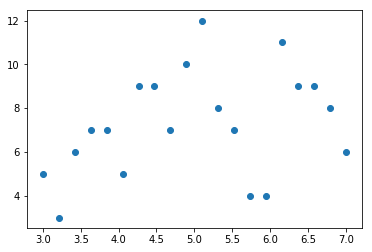

In [3]:
plt.scatter(data.x, data.y)

### GLMによる推定

In [4]:
formula = 'y ~ x'
data = data
family = sm.families.Poisson()
model = smf.glm(formula=formula, data=data, family=family)

In [5]:
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   20
Model:                            GLM   Df Residuals:                       18
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -45.018
Date:                Sun, 01 Mar 2020   Deviance:                       14.171
Time:                        11:43:36   Pearson chi2:                     13.6
No. Iterations:                     4   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5661      0.360      4.351      0.000       0.861       2.272
x              0.0833      0.068      1.219      0.223      -0.051       0.217
==============================================================================
"""

### 無情報事前分布

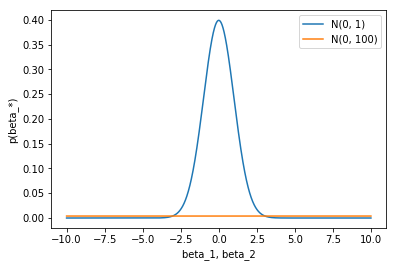

In [6]:
x = np.arange(-10.00, 10.01, 0.01)

plt.plot(x, [norm.pdf(x_i, 0, 1) for x_i in x], label='N(0, 1)')
plt.plot(x, [norm.pdf(x_i, 0, 100) for x_i in x], label='N(0, 100)')
plt.legend()
plt.xlabel('beta_1, beta_2')
plt.ylabel('p(beta_*)')
plt.show()

### Pymc3の実行
* MCMCのアルゴリズムは全部で3つ

In [7]:
#np.float128ではエラーとなったのでfloat64に型変換
data['x'] = data['x'].astype(np.float64)
data['y'] = data['y'].astype(np.float64)

In [8]:
with pymc3.Model() as model:
    # 事前分布をN(0, 100)の正規分布で設定
    beta1 = pymc3.Normal('beta1', mu=0, sd=100)
    beta2 = pymc3.Normal('beta2', mu=0, sd=100)
    
    # 線形予測子θをβ1+β2xで設定
    theta = beta1 + beta2*data['x'].values
    
    # ログリンク関数(log(μ)=θ⇔μ=exp(θ))を設定し、ポアソン分布で推定する
    y = pymc3.Poisson('y', mu=np.exp(theta), observed=data['y'].values)

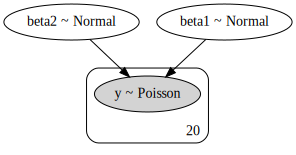

In [9]:
#可視化
pymc3.model_to_graphviz(model)

### NUTSでの推定
* 推定はできるがwarningが出ている...

In [38]:
#NUTS(No-U-Turn Sampler)
#stepを指定しない場合はデフォルトのNUTSが指定される
#chaneの数はnjobsではなくcoreで指定される。デフォルトのchaine数は2

#tuneの数が小さいと以下のようなメッセージが表示される
#The acceptance probability does not match the target. It is 0.9365575156498921, but should be close to 0.8. Try to increase the number of tuning steps.

#有効サンプル数のエラーが表示されるが解決策がわからない...
#The number of effective samples is smaller than 25% for some parameters.

#総サンプル取得数 = (sample数+tune数) * chain数

with model:
    #最初の1500回は捨て、その後の15000回分をサンプルとして取得する
    trace = pymc3.sample(15000, tune=1500, cores=2)
    
#収束は問題ない
#推定値もGMLとほぼ一致する
#pymc3.traceplot(trace)
#pymc3.plot_posterior(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta2, beta1]
Sampling 2 chains, 0 divergences: 100%|██████████| 33000/33000 [00:26<00:00, 1247.04draws/s]
The number of effective samples is smaller than 25% for some parameters.


/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c23f278d0>,
      dtype=object)

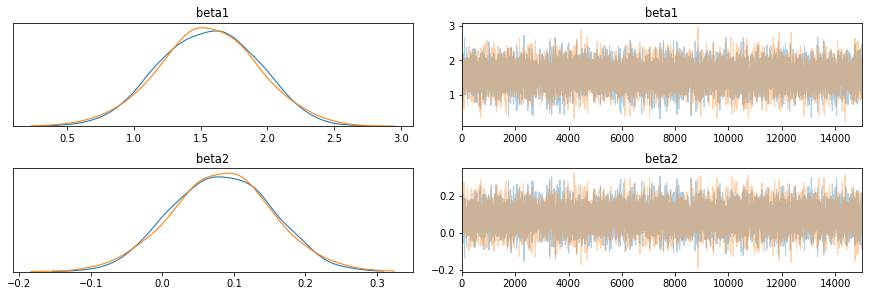

In [39]:
#traceplotはサンプリング過程と確率密度関数を可視化する
pymc3.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c24fd1080>,
      dtype=object)

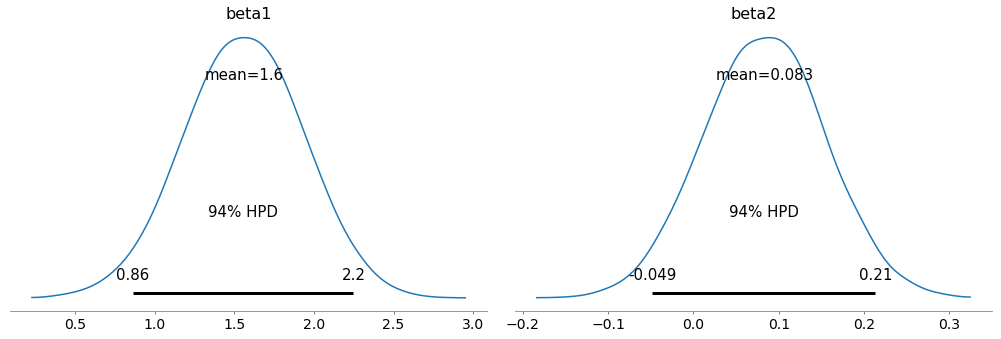

In [40]:
pymc3.plot_posterior(trace)

In [41]:
pymc3.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta1,1.559,0.37,0.862,2.248,0.005,0.004,5587.0,5587.0,5567.0,5449.0,1.0
beta2,0.083,0.07,-0.049,0.213,0.001,0.001,5565.0,5162.0,5545.0,5501.0,1.0


### メトロポリス法での推定

In [50]:
#メトロポリス法
with model:
    trace = pymc3.sample(15000, step=pymc3.Metropolis(), tune=1500)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta2]
>Metropolis: [beta1]
Sampling 2 chains, 0 divergences: 100%|██████████| 33000/33000 [00:06<00:00, 5226.33draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c254ee048>,
      dtype=object)

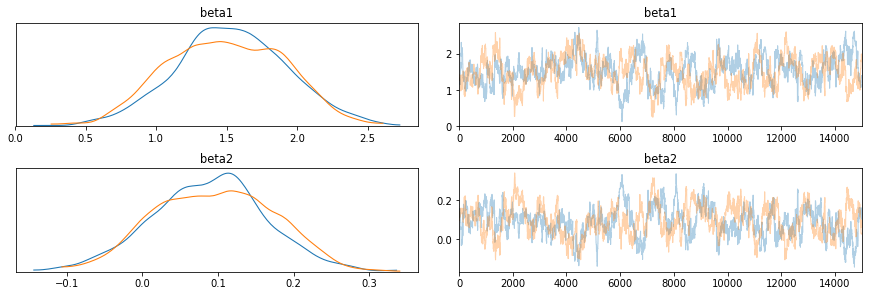

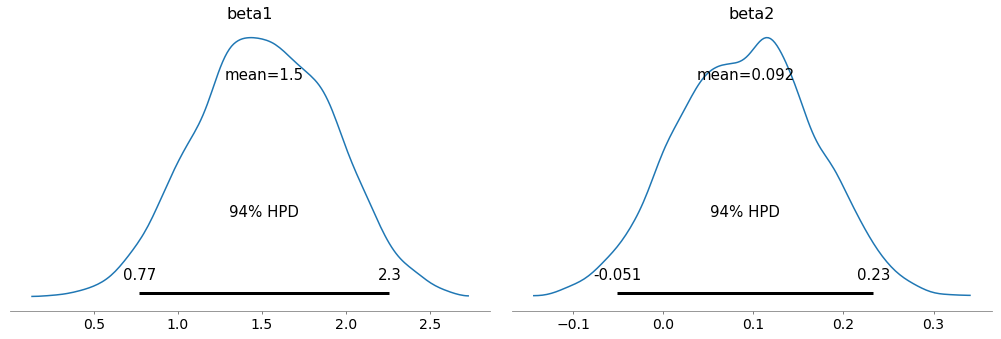

In [51]:
pymc3.traceplot(trace)
pymc3.plot_posterior(trace)

In [52]:
pymc3.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta1,1.514,0.405,0.772,2.260,0.039,0.028,106.0,106.0,106.0,236.0,1.01
beta2,0.092,0.077,-0.051,0.233,0.007,0.005,106.0,106.0,106.0,245.0,1.01


### ハミルトニアン法での推定
* 失敗してしまう...

In [42]:
#ハミルトニアン法
with model:
    trace = pymc3.sample(1000, step=pymc3.HamiltonianMC(), tune=1000)
    
pymc3.traceplot(trace)
pymc3.plot_posterior(trace)

Multiprocess sampling (2 chains in 2 jobs)
HamiltonianMC: [beta2, beta1]
Sampling 2 chains, 0 divergences:   5%|▌         | 206/4000 [00:00<00:06, 629.94draws/s] 


RuntimeError: Chain 0 failed.